# Exponential-family EKF

$$
\begin{aligned}
    p(\theta_t \vert \theta_{t-1}) &= {\cal N}(\theta_t \vert \theta_{t-1}, Q_t)\\
    p(y_t \vert \theta_{t}, {\bf x}_t) &= \text{expfam}(y_t \vert h(\theta_t, {\bf x}_t))\\
\end{aligned}
$$

In [1]:
import jax
import chex
import einops
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = "retina"

## Bernoulli

In [3]:
from sklearn.datasets import make_moons
from jax.flatten_util import ravel_pytree

In [4]:
n_samples = 200
data = make_moons(n_samples=n_samples, random_state=314, noise=0.15)
X, y = jax.tree_map(jnp.array, data)

key = jax.random.PRNGKey(314)

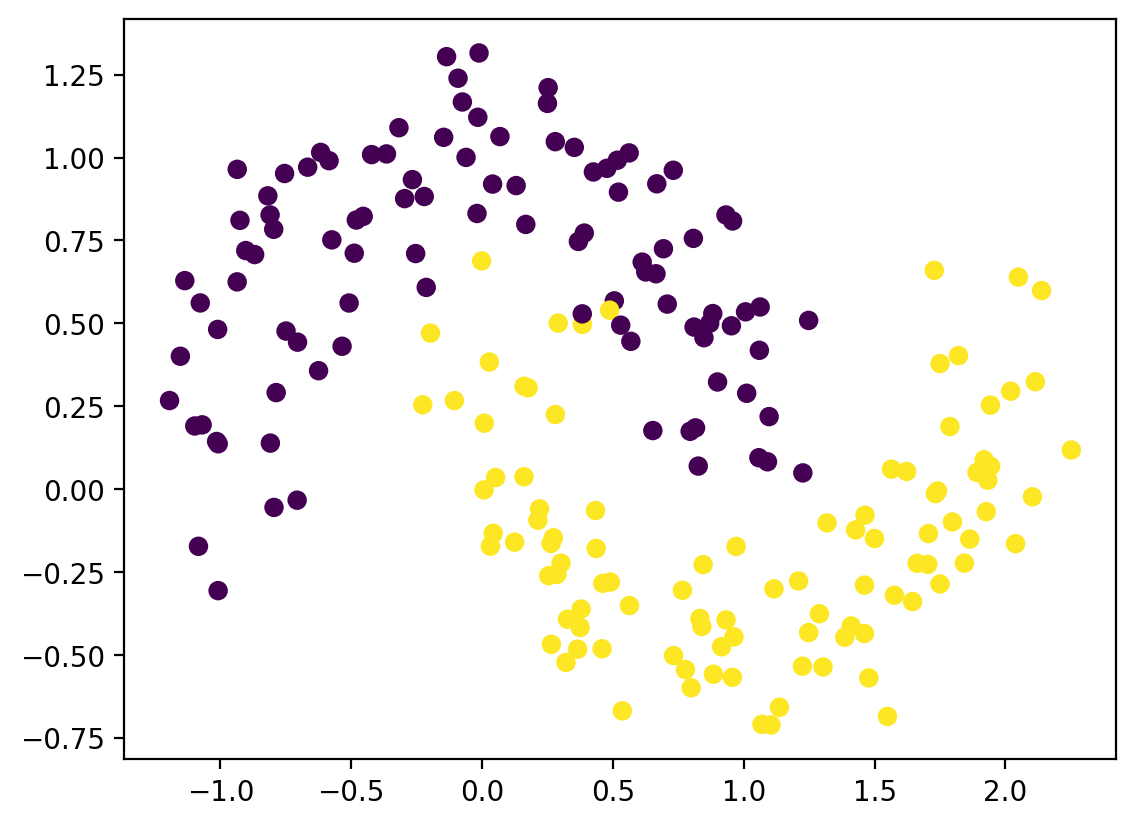

In [5]:
plt.scatter(*X.T, c=y)

In [6]:
@chex.dataclass
class Bel:
    mean: chex.Array
    cov: chex.Array

In [7]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.elu(x)
        x = nn.Dense(50)(x)
        x = nn.elu(x)
        x = nn.Dense(3)(x)
        x = nn.elu(x)
        x = nn.Dense(1)(x)
        return x # Eta
    
model = MLP()
params = model.init(key, X)
params, rfn = ravel_pytree(params)
nparams = len(params)

def applyfn(params, x):
    return model.apply(rfn(params), x)

In [8]:
@jax.jit
def log_partition(eta):
    return jnp.log(1 + jnp.exp(eta))

@jax.jit
def mean(eta):
    return jax.jacfwd(log_partition)(eta)

@jax.jit
def covariance(eta):
    return jax.hessian(log_partition)(eta).squeeze()

@jax.jit
def linkfn(params, x):
    eta = applyfn(params, x)
    return eta

In [9]:
bel_init = Bel(
    mean=params,
    cov=jnp.eye(nparams) * 2.0
)

In [10]:
dynamics_covariance = 0.0 # TODO: Change

dmodel = jax.jacfwd(applyfn)

def step(bel, xs):
    xt, yt = xs
    pcov_pred = bel.cov + dynamics_covariance
    pmean_pred = bel.mean
    nparams = len(pmean_pred)
    I = jnp.eye(nparams)
    
    eta = linkfn(bel.mean, xt).astype(float)
    yhat = mean(eta)
    err = yt - yhat
    Rt = covariance(eta)
    
    Ht = dmodel(pmean_pred, xt)
    # Kt = pcov_pred @ Ht.T @ jnp.linalg.inv(Ht @ pcov_pred @ Ht.T + Rt)
    Kt = jnp.linalg.solve(Ht @ pcov_pred @ Ht.T + Rt, Ht @ pcov_pred).T
    
    pcov = (I - Kt @ Ht) @ pcov_pred
    pmean = pmean_pred + (Kt @ err).squeeze()
    
    bel = bel.replace(mean=pmean, cov=pcov)
    return bel, bel

In [11]:
D = (X, y)
bel, bel_hist = jax.lax.scan(step, bel_init, D)

In [12]:
eta = linkfn(bel.mean, X)
yhat = jax.nn.sigmoid(eta) > 0.5

In [13]:
(y == yhat.squeeze()).mean()

Array(0.93, dtype=float32)

In [14]:
XX = np.mgrid[-1.5:2:0.05, -1.5:2:0.05]

In [15]:
Xeval = einops.rearrange(XX, "d x y -> x y d")

(-1.5, 2.0, -1.5, 2.0)

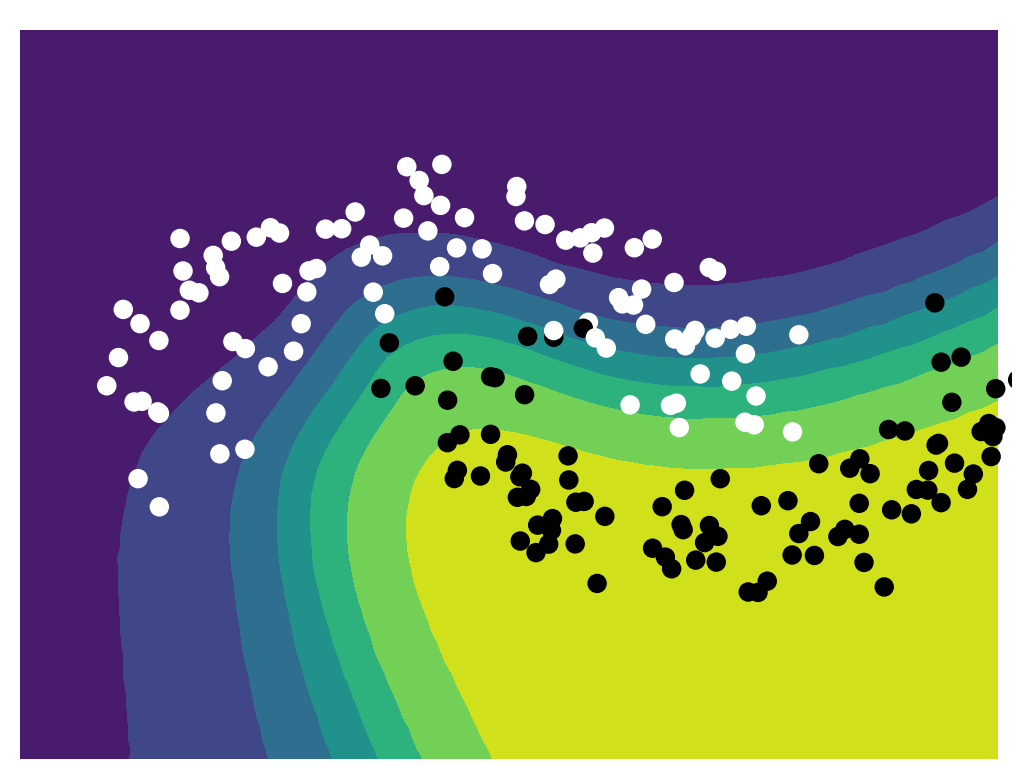

In [16]:
Z = np.array(applyfn(bel.mean, Xeval).squeeze())
plt.contourf(*XX, jax.nn.sigmoid(Z))
plt.scatter(*np.array(X).T, c=y, cmap="bone_r")
plt.ylim(-1.5, 2)
plt.xlim(-1.5, 2)
plt.axis("off")

## Animating

In [17]:
import numpy as np
from matplotlib.animation import FuncAnimation

MovieWriter ffmpeg unavailable; using Pillow instead.


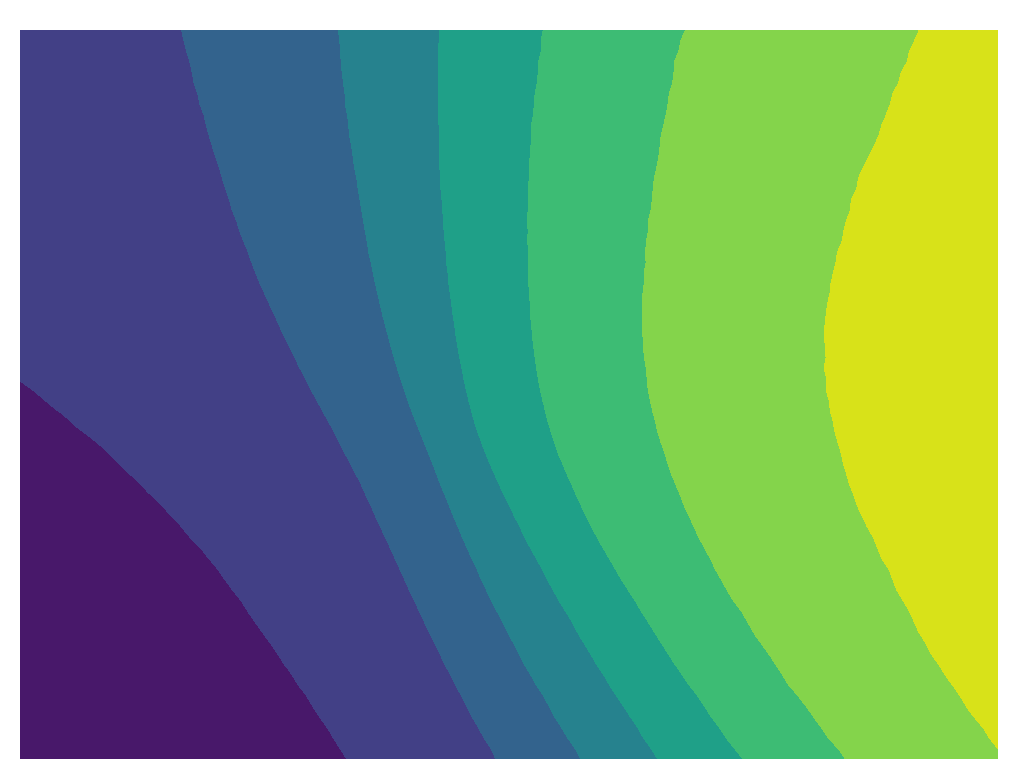

In [18]:
fig, ax = plt.subplots()

def anim(t):
    ax.cla()
    bel = jax.tree_map(lambda x: x[t], bel_hist)
    Z = np.array(applyfn(bel.mean, Xeval).squeeze())
    plt.contourf(*XX, jax.nn.sigmoid(Z))
    plt.scatter(*np.array(X)[:t].T, c=y[:t], cmap="bone_r")
    plt.ylim(-1.5, 2)
    plt.xlim(-1.5, 2)
    plt.axis("off")

frames = np.arange(n_samples)
animation = FuncAnimation(fig, anim, frames=frames)
animation.save("bern-ekf.gif", fps=20)

## References
* [The Extended Kalman Filter is a Natural Gradient Descent in Trajectory Space](http://www.yann-ollivier.org/rech/publs/kalnat.pdf)